In [1]:
# this makes the output 90% of the screen-width, instead of the usual narrow style
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# a couple of loggers for debugging purposes
import logging
logger = logging.getLogger() # basic logging level
logger.setLevel(logging.INFO)
entityLog = logging.getLogger(name="src.model.entity") # specific logging level
entityLog.setLevel(logging.INFO)

# <font size="200"> A small tutorial showing the use of CREST </font>
Thank you to [Jupyter](http://jupyter.org/) and [Binder](https://mybinder.org/) for building the base of interactive CREST.

Find this Notebook at MyBinder: https://mybinder.org/v2/gh/stklik/CREST/binder

# First import the necessary libraries

In [14]:
# import all model concepts
from src.model import *

# import the simulator
from src.simulator.simulator import Simulator

# import a library that can visualise our systems
from src.ui import dotter

## Define the resources that we use in the system

In [4]:
# define the resources in a class, so they are bundled. This is syntactic sugar.
# it is important however that none of the resources has the same name as any of the ports!
class Resources(object):
    electricity = Resource("Watt", FLOAT)
    switch = Resource("switch", ["on", "off"])
    light = Resource("Lumen", INTEGER)
    time = Resource("minutes", INTEGER)
    celsius = Resource("Celsius", FLOAT)
    fahrenheit = Resource("Fahrenheit", FLOAT)
    

## Let's define an entity
Entities derive from the basic 'Entity' class.  
They can define:
 - inputs, outputs and local variables
 - states and the current state
 - transitions between states
 - influences between ports (incl. transformations)
 - updates related to a port

In [5]:

# this is a definition of a new Entity type
# it derives from the Entity base class
class LightElement(Entity):
    # we define ports - each has a resource and an initial value
    electricity = Input(resource=Resources.electricity, value=0)
    light = Output(resource=Resources.light, value=0)
    
    # automata states - don't forget to specify one as the current state
    on = State()
    off = current = State()
    
    # transitions and guards (as lambdas)
    off_to_on = Transition(source=off, target=on, guard=(lambda self: self.electricity.value >= 100))
    on_to_off = Transition(source=on, target=off, guard=(lambda self: self.electricity.value < 100))
    
    # update functions are related to a state and define the value of a port
    @update(state=on, target=light)
    def set_light_on(self, dt=0):
        return 800

    @update(state=off, target=light)
    def set_light_off(self, dt=0):
        return 0

## Plotting
We use the dotter library to create a graphviz-dot based system representation.

We can pass Boolean-valued options into the function call to adjust the output.  
Options are as follows (incl. default values)
 - updates = True
 - update_labels = False
 - transitions = True
 - transition_labels = False
 - influence_labels = False
 - interface_only = False
 - no_behaviour = False
 - show_update_ports = False
 
 
** GO AHEAD AND TRY IT **

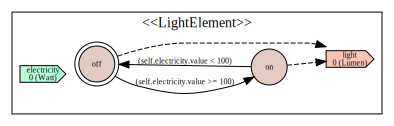

In [6]:
dotter.plot(LightElement(), transition_labels=True)

## Define another entity (without state ??)
Note that this one does not have a state automaton.  
 -- actually we can argue that it does have a state that is always the current state and we just don't show it, but that's semantics)

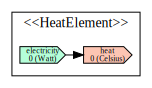

In [7]:
class HeatElement(Entity):
    electricity = Input(resource=Resources.electricity, value=0)
    heat = Output(resource=Resources.celsius, value=0)
        
    # define an influence function
    @influence(source=electricity, target=heat)
    def heat_output(value):
        return value / 100

# show us what it looks like
dotter.plot(HeatElement())
    

# Logical Entities

These entities are just like any other entity.  
We however specify explicitly that they do not have real world counterparts.

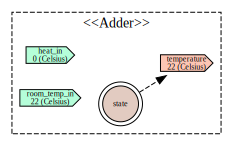

In [8]:
# a logical entity (this one sums two values)
class Adder(LogicalEntity):
    heat_in = Input(resource=Resources.celsius, value=0)
    room_temp_in = Input(resource=Resources.celsius, value=22)
    temperature = Output(resource=Resources.celsius, value=22)
    
    state = current = State()
    @update(state=state, target=temperature)
    def add(self, dt):
        return self.heat_in.value + self.room_temp_in.value
    
dotter.plot(Adder())  # try adding the display option 'show_update_ports=True' and see what happens!

## A more complex entity (incl. subentities)
The GrowLamp is a standard entity just like the ones above, except...  
... it defines subentities !!

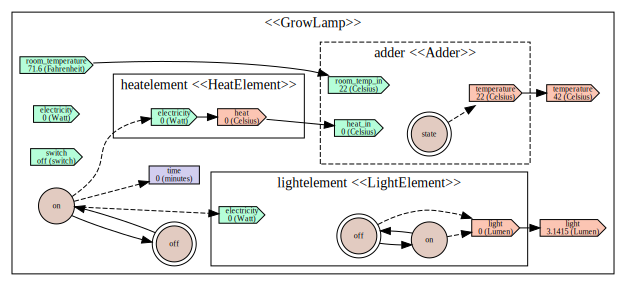

In [9]:
class GrowLamp(Entity):
    # interface
    electricity = Input(resource=Resources.electricity, value=0)
    switch = Input(resource=Resources.switch, value="off")
    room_temperature = Input(resource=Resources.fahrenheit, value=71.6)
    light = Output(resource=Resources.light, value=3.1415)
    temperature = Output(resource=Resources.celsius, value=42)
    
    # states & transitions
    on = State()
    off = current = State()
    
    off_to_on = Transition(source=off, target=on, guard=(lambda self: self.switch.value == "on" and self.electricity.value >= 100))
    on_to_off = Transition(source=on, target=off, guard=(lambda self: self.switch.value == "off" or self.electricity.value < 100))
    time = Local(resource=Resources.time, value=0)
    
    # subentitites
    lightelement = LightElement()
    heatelement = HeatElement()
    adder = Adder()
    
    @update(state=on, target="lightelement.electricity")
    def update_light_elec(self, dt):
        return 100
    
    @update(state=on, target="heatelement.electricity")
    def update_heat_elec(self, dt):
        return self.electricity.value - 100
        
    @update(state=on, target=time)
    def update_time(self, dt):
        return self.time.value + dt
        
    @influence(source=room_temperature, target=adder.room_temp_in)
    def fahrenheit_to_celsius(value):
        return (value - 32) * 5 / 9
    
    # we can also define updates and influences with lambda functions... 
    heat_to_add = Influence(source=heatelement.heat, target=adder.heat_in, function=(lambda val: val))
    
    # if the lambda function doesn't do anything (like the one above) we can omit it...
    add_to_temp = Influence(source=adder.temperature, target=temperature)
    light_to_light = Influence(source=lightelement.light, target=light)

# create an instance!
gl = GrowLamp()
dotter.plot(gl)

## We are now going to use the Simulator
A simulator is initialized with a root-entity and a time domain.
For convenience we can define which plotter to use too.

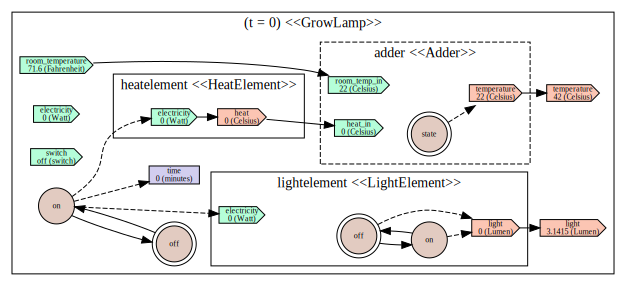

In [10]:
sim = Simulator(gl, timeunit=REAL, plotter=dotter)
sim.plot() # the plotting should be the same as above -- except for the current time, that is!

## Stabilisation
The simulator can run the system until it is stable.  
I.e. until there is a fixpoint, where all influences have been propagated and the updates have written their port values.  
Look specifically at the **output** values, they are now correct !!

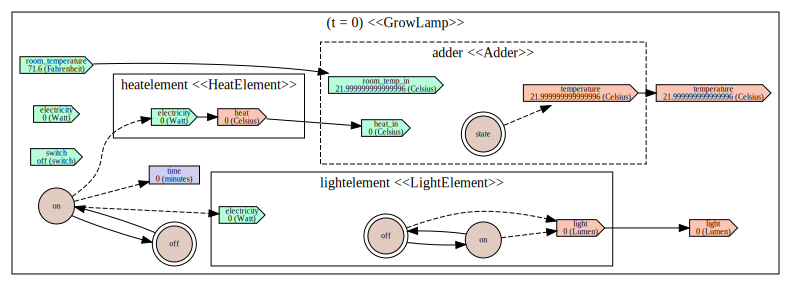

In [11]:
sim.stabilise_fp()
sim.plot()

## modification of the input values

if we modify the input values now, we see that nothing happens except what we changed  
it actually takes another *stabilisation_fp* to propagate the values

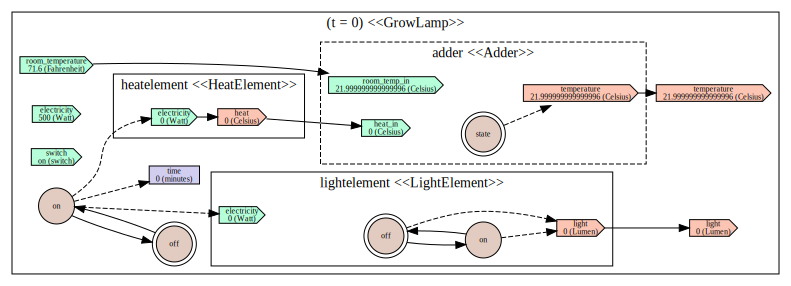

In [12]:
gl.electricity.value = 500
gl.switch.value = "on"
sim.plot()

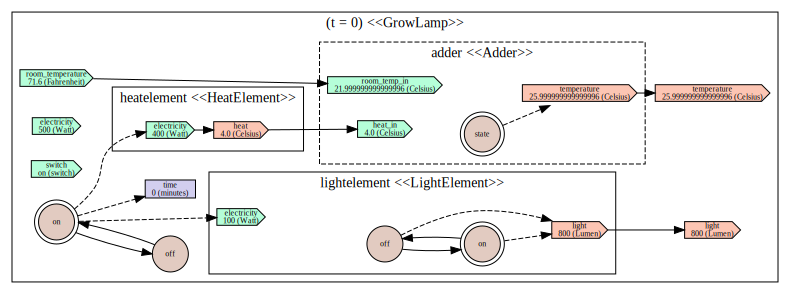

In [13]:
sim.stabilise_fp()
sim.plot()

## Time advance

# <font color='red'>There is a bug here, we cannot really look at this here yet. Seems to be with discrete domains such as [on/off]</font>